We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

# modules, functions

In [1]:
import pandas as pd

# for feature engineering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

# for modeling
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

# for interpretation
import shap

# for visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sns
import numpy as np

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
## some commonly used functions

class features_transformer(object): # assuming all features have been converted to numerics
    
    def fit(self, X, y=None):
        self.mean = X.mean() # learn the mean value of each feature; can we do better imputation?
        
    def transform(self, X, y=None):
        return X.fillna(self.mean) # impute missing entries with learned mean value
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


# convert non-categorical features (cost, price, size/dimension, weight) to numerics 
class text2num():

    def cost2num(self, x):
        if isinstance(x, str):
            x = x.strip('$').strip('k')
            return float(x)/1e3 #unit million
        else:
            return x

    def price2num(self, x):
        if isinstance(x, str): 
            x = x.strip("$").replace(",", "")
            return float(x)/1e6 # unit million
        else:
            return x

    def weight2num(self, x):
        if isinstance(x, str): 
            res = x.strip(' Kg').split(' Ton ') 
            return float(res[0])+float(res[1])/1e3 # unit tons
        else:
            return x

    def height2num(self, x):
        if isinstance(x, str):
            x = x.strip(" meters")
            return float(x) # unit meter 
        else:
            return x
        
    def width2num(self, x):
        if isinstance(x, str):
            x = x.strip(" cm")
            return float(x)/1e2 # unit meter 
        else:
            return x
        
    def depth2num(self, x):
        if isinstance(x, str):
            x = x.strip(" cm")
            return float(x)/1e2 # unit meter 
        else:
            return x


# calculate train/test scores
def train_test_score(model, X_train, y_train, X_test, y_test, slient=False):   
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    if not slient:
        print('train MAE: %.2e'%train_mae)
        print('train MSE: %.2e'%train_mse)
        print('train R2: %.3f'%train_r2)
        print('-----------')
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    if not slient:
        print('train MAE: %.2e'%test_mae)
        print('train MSE: %.2e'%test_mse)
        print('train R2: %.3f'%test_r2)
    return train_mae, train_mse, train_r2, test_mae, test_mse, test_r2


def visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2):
    fig = plt.figure(figsize=[6,3.2])
    gs = grd.GridSpec(2, 2, height_ratios=[8,2], width_ratios=[1,1], wspace=0.4, hspace=0.55)
    # ------- train data ---------
    ax1 = fig.add_subplot(gs[0])
    sns.regplot(ax=ax1, x=y_train, y=y_train_pred, scatter_kws={'alpha':0.3,'s':1,'color':'blue'},line_kws={'color':'red', 'linestyle':'--'})
    ax1.set_title('train R2: %.3f'%train_r2, fontsize=12)
    ax1.set_xlim(0,1); ax1.set_ylim(0,1)
    ax1.set_xlabel('Actual Price (M$)', fontsize=10)
    ax1.set_ylabel('Predicted Price (M$)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1 = fig.add_subplot(gs[2])
    residuals = y_train - y_train_pred
    sns.histplot(residuals, ax=ax1, kde=True,bins=50, color='purple')
    ax1.set_xlabel('Prediction Error (M$)', fontsize=10); ax1.set_xlim(-1,1)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.axvline(0, color='red', linestyle='--')
    ax1.grid(alpha=0.3)
    # ------- test data ---------
    ax1 = fig.add_subplot(gs[1])
    sns.regplot(ax=ax1, x=y_test, y=y_test_pred, scatter_kws={'alpha':0.3,'s':1,'color':'blue'},line_kws={'color':'red', 'linestyle':'--'})
    ax1.set_title('test R2: %.3f'%test_r2, fontsize=12)
    ax1.set_xlim(0,1); ax1.set_ylim(0,1)
    ax1.set_xlabel('Actual Price (M$)', fontsize=10)
    ax1.set_ylabel('Predicted Price (M$)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1 = fig.add_subplot(gs[3])
    residuals = y_test - y_test_pred
    sns.histplot(residuals, ax=ax1, kde=True,bins=50, color='purple')
    ax1.set_xlabel('Prediction Error (M$)', fontsize=10); ax1.set_xlim(-1,1)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.axvline(0, color='red', linestyle='--')
    ax1.grid(alpha=0.3)
    # plt.tight_layout()



# 1. FEATURE ENGINEERING
- initial inspection & cleaning: check for missing values or outliers and either fix or remove them
- preprocessing: convert text into numbers, perform proper encoding for categorical features; append properly processed features to the dataset (keep original features for easy cross checks); (data rescaling will be done in pipeline)
- exploratory analysis: use histograms to understand how prices are distributed; use scatter plots and correlation heatmaps to see which features (maker, size, ingredient, etc.) most influence price; create new features or reduce redundant features when possible

## 1.1 inital inspection
- non-categorical: 
    - cost: ~30% entries missing; may need better imputation than just using the mean value
    - weight:
    - purchase_date:
    - volume (height, width, depth):
- categorical: 
    - product_type: each product may have multiple types; 2% unique, i.e. many products share the same type combination 
    - product_level: only 5 unique levels; each product has only one level; very small uniqueness, i.e. many products of the same product_level
    - maker: 25% data missing; each product can have multiple makers; 37% uniqueness
    - ingredient: 8% data missing; each product can have mulitple ingredient components; 96% uniqueness, i.e. nearly every product has a unique ingredient combination

#### - load dataset

In [3]:
df = pd.read_csv('../sales.csv') 
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [ ]:
# obtain statistics of the dataset
df_stats = df.describe()
# add two rows showing the perpecent of count and unique
df_stats.loc['count%'] = np.round(list(df_stats.iloc[0,:]/df.shape[0]*100),2) # count/all 
df_stats.loc['unique%'] = np.round(list(df_stats.iloc[1,:]/df_stats.iloc[0,:]*100),2) # unique/count
df_stats

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2216,3186,3193,3196,3196,3196,2373,2941,3197,3193,3193
unique,185,3157,119,1278,64,5,882,2833,161,41,13
top,$66k,"$20,061",3 Ton 0 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,127,8,485,1323,17,8,63,268,903
count%,69.31,99.66,99.87,99.97,99.97,99.97,74.23,91.99,100.0,99.87,99.87
unique%,8.35,99.09,3.73,39.99,2.0,0.16,37.17,96.33,5.04,1.28,0.41


In [5]:
df_stats[['product_level','maker','ingredient']]

,product_level,maker,ingredient
count,3196,2373,2941
unique,5,882,2833
top,advanced,M14196,IN732638
freq,1323,17,8
count%,99.97,74.23,91.99
unique%,0.16,37.17,96.33


#### - drop null row of price

In [4]:
# drop null rows of price (removed 11 rows)
df.dropna(subset=['price'], inplace=True) 
df.shape

(3186, 11)

## 1.2 cost, weight, volume
- height, width, depth are highly correlated; combine them as a new feature "volume", i.e. reducing the number of features by 2
- weight and volume are highly correlated; needs to drop either of them 

#### - convert text to numbers

In [9]:
# convert volume, weight, cost, price to numerics
t2n = text2num()
df['height_num'] = df.height.map(t2n.height2num)
df['width_num'] = df.width.map(t2n.width2num)
df['depth_num'] = df.depth.map(t2n.depth2num)
df['weight_num'] = df.weight.map(t2n.weight2num)
df['cost_num'] = df.cost.map(t2n.cost2num)
df['price_num'] = df.price.map(t2n.price2num)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,...,year,month,weekday,day,height_num,width_num,depth_num,weight_num,cost_num,price_num
0,$333k,"$300,492",3 Ton 90 Kg,2008-12-19,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,...,2008.0,12.0,4.0,19.0,2.76,0.97,0.26,3.09,0.333,0.300492
1,NaN,"$430,570",3 Ton 30 Kg,1997-09-10,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,...,1997.0,9.0,2.0,10.0,2.67,0.98,0.26,3.03,NaN,0.430570
2,$270k,"$213,070",3 Ton 40 Kg,2001-09-05,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,...,2001.0,9.0,2.0,5.0,3.00,0.93,0.24,3.04,0.270,0.213070
3,NaN,"$229,174",3 Ton 50 Kg,2016-12-23,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,...,2016.0,12.0,4.0,23.0,2.50,1.02,0.27,3.05,NaN,0.229174
4,$97k,"$122,659",2 Ton 970 Kg,2000-01-12,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,...,2000.0,1.0,2.0,12.0,2.47,1.01,0.26,2.97,0.097,0.122659


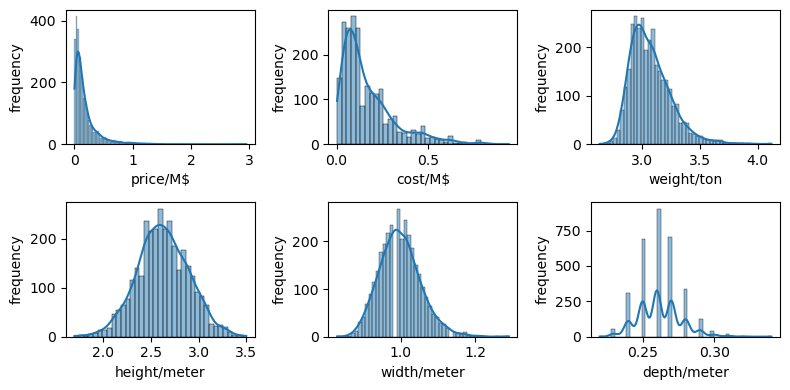

In [15]:
# visualize these non-categ. data distribution
fig, axes = plt.subplots(2,3,figsize=[8,4])
bins=50
ax1=axes[0,0]; sns.histplot(df['price_num'], kde=True,ax=ax1); ax1.set_xlabel('price/M$');ax1.set_ylabel('frequency')
ax1=axes[0,1]; sns.histplot(df['cost_num'], kde=True,ax=ax1); ax1.set_xlabel('cost/M$');ax1.set_ylabel('frequency')
ax1=axes[0,2]; sns.histplot(df['weight_num'], kde=True,ax=ax1); ax1.set_xlabel('weight/ton');ax1.set_ylabel('frequency')
ax1=axes[1,0]; sns.histplot(df['height_num'], kde=True,ax=ax1); ax1.set_xlabel('height/meter');ax1.set_ylabel('frequency')
ax1=axes[1,1]; sns.histplot(df['width_num'], kde=True,ax=ax1); ax1.set_xlabel('width/meter');ax1.set_ylabel('frequency')
ax1=axes[1,2]; sns.histplot(df['depth_num'], kde=True,ax=ax1); ax1.set_xlabel('depth/meter');ax1.set_ylabel('frequency')
plt.tight_layout()

#### - feature correlation, reduction

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.02, 'Pairplot')

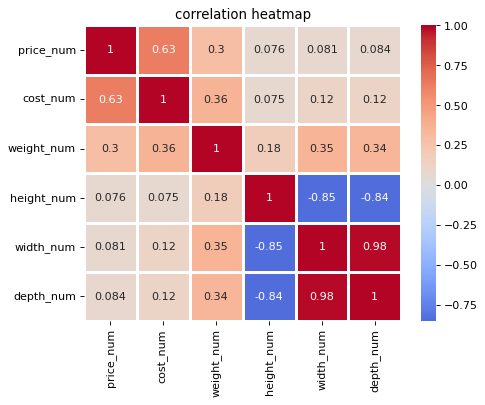

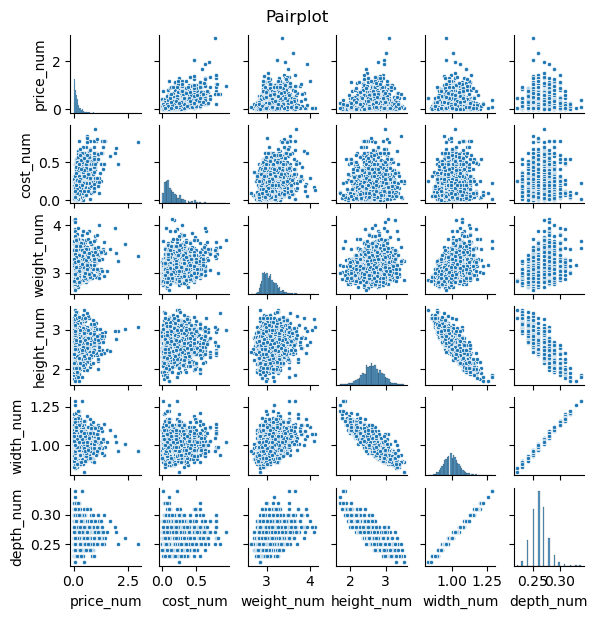

In [63]:
num_features = df[['price_num','cost_num','weight_num','height_num','width_num','depth_num']]

correlation_matrix = num_features.corr(method='pearson')
plt.figure(dpi=80); plt.title('correlation heatmap')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1)

sns.pairplot(num_features, markers='.',size=1.)
plt.suptitle('Pairplot', y=1.02)

[0.58268636 0.26870943 0.14196515 0.00539158 0.00124747]


Text(0, 0.5, 'variance ratio')

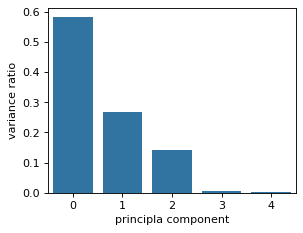

In [ ]:
# PCA confirmation
num_features = df[['cost_num','weight_num','height_num','width_num','depth_num']]
steps = [("ftf", features_transformer()), 
         ("rescale", MinMaxScaler())
         ]
model = Pipeline(steps)
X = model.fit_transform(num_features)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

plt.figure(figsize=[4,3],dpi=80)
sns.barplot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.xlabel('principla component')
plt.ylabel('variance ratio')

#### - create new feature volume

In [10]:
df['volume'] = df['height_num'] * df['width_num'] * df['depth_num'] # unit m^3
# df.head().T

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.02, 'Pairplot')

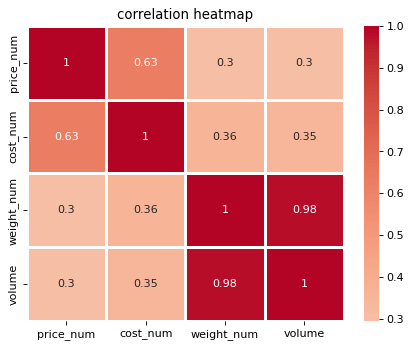

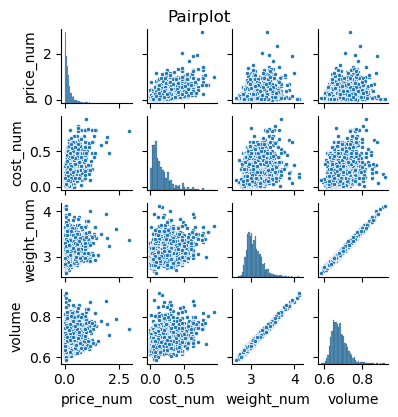

In [31]:
num_features = df[['price_num','cost_num','weight_num','volume']]

correlation_matrix = num_features.corr(method='pearson')
plt.figure(dpi=80); plt.title('correlation heatmap')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1)

sns.pairplot(num_features, markers='.',size=1.)
plt.suptitle('Pairplot', y=1.02)

[0.69675691 0.29715118 0.00609191]


Text(0, 0.5, 'variance ratio')

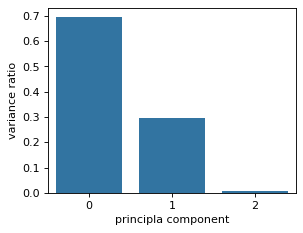

In [11]:
# PCA confirmation
num_features = df[['cost_num','weight_num','volume']]
steps = [("ftf", features_transformer()), 
         ("rescale", MinMaxScaler())
         ]
model = Pipeline(steps)
X = model.fit_transform(num_features)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

plt.figure(figsize=[4,3],dpi=80)
sns.barplot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.xlabel('principla component')
plt.ylabel('variance ratio')

## 1.3 time series (purchase_date)
- add year, month, weekday, day features

In [10]:
# add year, month, weekday, day columns based on purchase_date
df['purchase_date'] = pd.to_datetime(df.purchase_date)
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month
df['weekday'] = df['purchase_date'].dt.weekday
df['day'] = df['purchase_date'].dt.day
df.head().T

,0,1,2,3,4
cost,$333k,NaN,$270k,NaN,$97k
price,"$300,492","$430,570","$213,070","$229,174","$122,659"
weight,3 Ton 90 Kg,3 Ton 30 Kg,3 Ton 40 Kg,3 Ton 50 Kg,2 Ton 970 Kg
purchase_date,2008-12-19 00:00:00,1997-09-10 00:00:00,2001-09-05 00:00:00,2016-12-23 00:00:00,2000-01-12 00:00:00
product_type,"Q,B","J,D","J,D",U,"D,R"
product_level,advanced,basic,basic,advanced,advanced
maker,M14122,NaN,NaN,M14123,NaN
ingredient,"IN732052,IN732053","IN732054,IN732055,IN732056,IN732057,IN732058","IN732054,IN732059,IN732060","IN732061,IN732062,IN732063","IN732064,IN732065,IN732066"
height,2.76 meters,2.67 meters,3.0 meters,2.5 meters,2.47 meters
width,97 cm,98 cm,93 cm,102 cm,101 cm


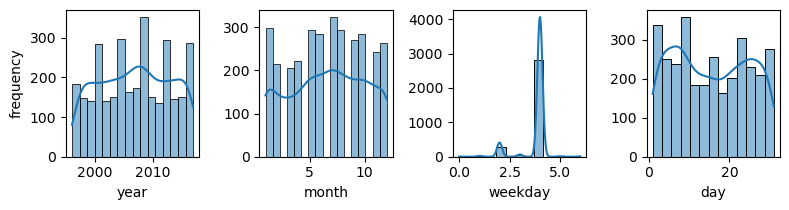

In [19]:
fig, axes = plt.subplots(1,4,figsize=[8,2.2])
bins=50
ax1=axes[0]; sns.histplot(df['year'], kde=True,ax=ax1); ax1.set_xlabel('year');ax1.set_ylabel('frequency')
ax1=axes[1]; sns.histplot(df['month'], kde=True,ax=ax1); ax1.set_xlabel('month');ax1.set_ylabel('')
ax1=axes[2]; sns.histplot(df['weekday'], kde=True,ax=ax1); ax1.set_xlabel('weekday');ax1.set_ylabel('')
ax1=axes[3]; sns.histplot(df['day'], kde=True,ax=ax1); ax1.set_xlabel('day');ax1.set_ylabel('')
# ax1=axes[1,1]; sns.histplot(df['width_num'], kde=True,ax=ax1); ax1.set_xlabel('width/meter');ax1.set_ylabel('count')
# ax1=axes[1,2]; sns.histplot(df['depth_num'], kde=True,ax=ax1); ax1.set_xlabel('depth/meter');ax1.set_ylabel('count')
plt.tight_layout()

<Axes: xlabel='year'>

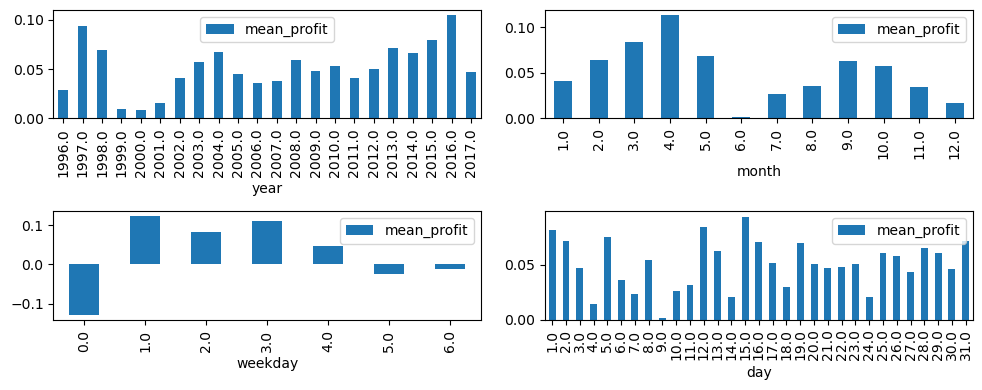

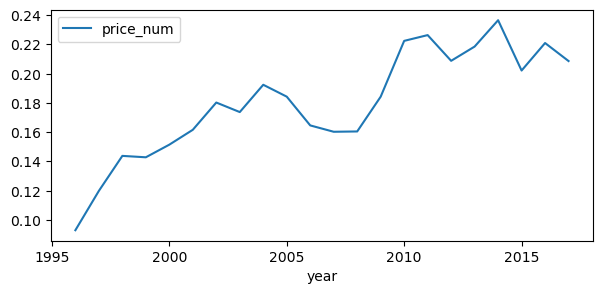

In [25]:
profit = df['price_num'] - df['cost_num']
profit.index = pd.to_datetime(df.purchase_date)
profit.head()

fig, axes = plt.subplots(2,2,figsize=[10,4])
ax1=axes[0,0]
dt_type = 'year'
profit_tmp = pd.DataFrame({'mean_profit': profit.values, dt_type: pd.to_datetime(df.purchase_date).dt.year})
profit_tmp.groupby(dt_type).mean().plot(kind = 'bar', ax=ax1)
ax1=axes[0,1]
dt_type = 'month'
profit_tmp = pd.DataFrame({'mean_profit': profit.values, dt_type: pd.to_datetime(df.purchase_date).dt.month})
profit_tmp.groupby(dt_type).mean().plot(kind = 'bar', ax=ax1)
ax1=axes[1,0]
dt_type = 'weekday'
profit_tmp = pd.DataFrame({'mean_profit': profit.values, dt_type: pd.to_datetime(df.purchase_date).dt.weekday})
profit_tmp.groupby(dt_type).mean().plot(kind = 'bar', ax=ax1)
ax1=axes[1,1]
dt_type = 'day'
profit_tmp = pd.DataFrame({'mean_profit': profit.values, dt_type: pd.to_datetime(df.purchase_date).dt.day})
profit_tmp.groupby(dt_type).mean().plot(kind = 'bar', ax=ax1)
plt.tight_layout()

price_tmp = df[['price_num','year']]
price_tmp.groupby('year').mean().plot(kind = 'line', figsize=[7,3])

## 1.4 product_type 
- total 23 individual types
- first 10 types accounts for ~86% of the total count
- first 15 types accounts for ~97% of the total count
- we may do one-hot encoding for first few types
- we may also do one-hot encoding for all types since it does not increase computation much

In [65]:
df.product_type.unique()

array(['Q,B', 'J,D', 'U', 'D,R', 'H', 'S', 'B,A', 'K,D', 'N', 'U,A', 'D',
       'H,A', 'G', 'D,A', 'T,H', 'D,H', 'F', 'A', 'Q,A', 'W', 'F,D', 'R',
       'P,H', 'C', 'Q,H', 'U,H', 'J', 'N,D', 'F,H', 'Q,D', 'V,H', 'W,D',
       'S,N', 'N,U', 'F,U', 'P,P', 'S,A', 'U,R', 'J,B', 'I,M', 'B,D',
       'H,M', 'S,U', 'K,H', 'S,B', 'T,D', 'F,A', 'K', 'V', 'N,A', 'B',
       'R,V', 'E', 'U,D', 'L,A', 'L', 'K,A', 'S,D', 'Q,N', 'T,A', 'O',
       'B,R', 'N,L', 'K,S'], dtype=object)

<Axes: ylabel='product_type'>

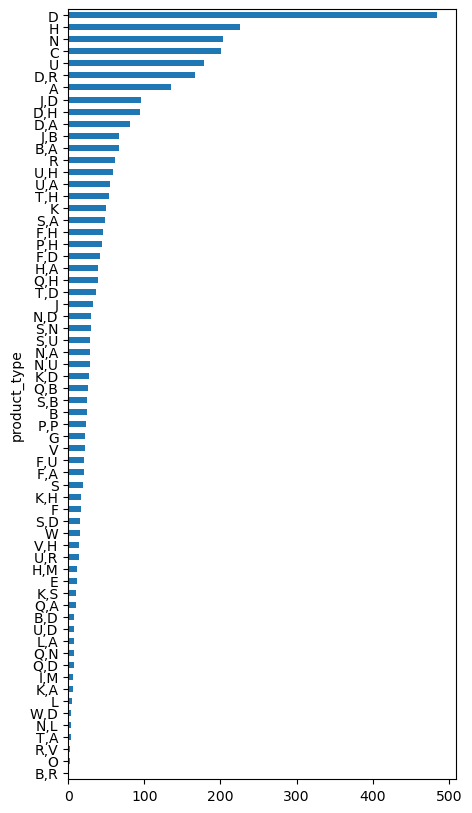

In [34]:
df.product_type.value_counts(ascending=True).plot(kind='barh',figsize=[5,10])

#### - sort individual types

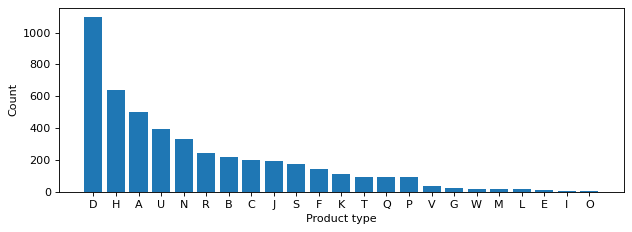

In [7]:
# split and count for each individual type
map = {}
for e in df.product_type:
    if type(e) == str:
        tmp = e.split(',')
        for i in tmp:
            map[i] = map.get(i,0)+1

sorted_types = sorted(map.items(), key=lambda item:item[1], reverse=True)
product_type, count = zip(*sorted_types)

plt.figure(figsize=[8,3],dpi=80)
plt.bar(product_type, count)
plt.xlabel('Product type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

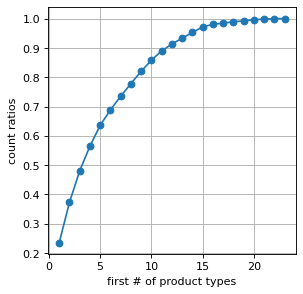

In [12]:
# see how many counts for the first few types (types in descending order)
first_ratios = []
tot = 0
for key, val in sorted_types:
    tot += val
    first_ratios.append(tot)
first_ratios = np.array(first_ratios)/tot
plt.figure(figsize=[4,4],dpi=80)
plt.plot(range(1,len(sorted_types)+1), first_ratios,'-o')
plt.grid(which='both')
plt.xlabel('first # of product types')
plt.ylabel('count ratios')
df_first_types = pd.DataFrame({'first ratios': first_ratios})
df_first_types.index +=1 
# df_first_types


#### - one-hot encoding of product types

In [13]:
# column to temporarily store lists of the product types 
df['product_type_tmp'] = df['product_type'].apply(lambda x: [tag.strip() for tag in x.split(',')] if type(x)==str else [])

# individual types to create as new features
new_types = []
for i in sorted_types[0:15]:
    new_types.append(i[0])
new_types.append('Other')

for tag in new_types:
    df[f'type_{tag}'] = df['product_type_tmp'].apply(lambda x: 1 if tag in x else 0)

df.drop(columns='product_type_tmp', inplace=True)

df.head().T

,0,1,2,3,4
cost,$333k,NaN,$270k,NaN,$97k
price,"$300,492","$430,570","$213,070","$229,174","$122,659"
weight,3 Ton 90 Kg,3 Ton 30 Kg,3 Ton 40 Kg,3 Ton 50 Kg,2 Ton 970 Kg
purchase_date,Dec 19 2008,Sep 10 1997,Sep 05 2001,Dec 23 2016,Jan 12 2000
product_type,"Q,B","J,D","J,D",U,"D,R"
product_level,advanced,basic,basic,advanced,advanced
maker,M14122,NaN,NaN,M14123,NaN
ingredient,"IN732052,IN732053","IN732054,IN732055,IN732056,IN732057,IN732058","IN732054,IN732059,IN732060","IN732061,IN732062,IN732063","IN732064,IN732065,IN732066"
height,2.76 meters,2.67 meters,3.0 meters,2.5 meters,2.47 meters
width,97 cm,98 cm,93 cm,102 cm,101 cm


## 1.5 product_level
- price shows negative correlation with product_level (which is a little counter-intuitive)
- it could be that there are too few product_level options to describe the price variance
- we may also try frequency encoding?

<Axes: ylabel='product_level'>

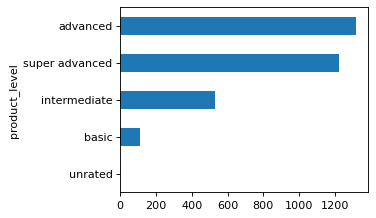

In [ ]:
plt.figure(figsize=[4,3],dpi=80)
df.product_level.value_counts(ascending = True).plot(kind = 'barh')

In [32]:
df.product_level.value_counts(ascending = True)

product_level
unrated              1
basic              111
intermediate       532
super advanced    1222
advanced          1320
Name: count, dtype: int64

#### - label encoding of product level

In [14]:
# ordinal transformer for the categorical feature 'product_level'
# only 1 entry as 'unrated'; otherwise we may impute it as mean value
# basic-->super advanced does not necessarily follow linear scale. 
def convert_level_2_ordinal(x):
    convert = {"unrated": 2.5, "basic": 1, "intermediate": 2, "advanced": 3, "super advanced": 4}
    if x in convert:
        return convert[x]
    else:
        return x

df['product_level_num'] = df['product_level'].map(convert_level_2_ordinal)
df.head().T

,0,1,2,3,4
cost,$333k,NaN,$270k,NaN,$97k
price,"$300,492","$430,570","$213,070","$229,174","$122,659"
weight,3 Ton 90 Kg,3 Ton 30 Kg,3 Ton 40 Kg,3 Ton 50 Kg,2 Ton 970 Kg
purchase_date,Dec 19 2008,Sep 10 1997,Sep 05 2001,Dec 23 2016,Jan 12 2000
product_type,"Q,B","J,D","J,D",U,"D,R"
product_level,advanced,basic,basic,advanced,advanced
maker,M14122,NaN,NaN,M14123,NaN
ingredient,"IN732052,IN732053","IN732054,IN732055,IN732056,IN732057,IN732058","IN732054,IN732059,IN732060","IN732061,IN732062,IN732063","IN732064,IN732065,IN732066"
height,2.76 meters,2.67 meters,3.0 meters,2.5 meters,2.47 meters
width,97 cm,98 cm,93 cm,102 cm,101 cm


## 1.6 maker
- 37% uniqueness, 883 unqiue tags, high cardinality, not suitable for one-hot, label incoding
- will do a simple frequency encoding

In [15]:
df['maker'].unique().shape

(883,)

#### - frequency encoding of maker

In [15]:
# frequency encoding for maker
maker_freq = {}
makers = list(df.maker.unique())
for maker in makers:
    maker_freq[maker] = df[df['maker']==maker]['maker'].count()

df['maker_freq'] = df['maker'].map(lambda x: maker_freq[x])
# df.head().T

## 1.7 ingredient
- high cardinality (96% uniqueness, close to one unique type per row), which precludes one-hot encoding (sparse matrix, memory inefficient, overfitting risk) or label encoding (imposes a false order)
- will do a simple frequency encoding; or drop this feature entirely
- alternatives include target encoding, hashing encoding

In [13]:
df['ingredient'].unique().shape

(2834,)

#### - frequency encoding of ingredient

In [16]:
ingredient_freq = {}
ingredients = list(df.ingredient.unique())
for ingredient in ingredients:
    ingredient_freq[ingredient] = df[df['ingredient']==ingredient]['ingredient'].count()

df['ingredient_freq'] = df['ingredient'].map(lambda x: ingredient_freq[x])
# df.head().T

## 1.7 purchase_date

purchase_date
2008-12-19   -0.032508
1997-09-10         NaN
2001-09-05   -0.056930
2016-12-23         NaN
2000-01-12    0.025659
dtype: float64

<Axes: xlabel='year'>

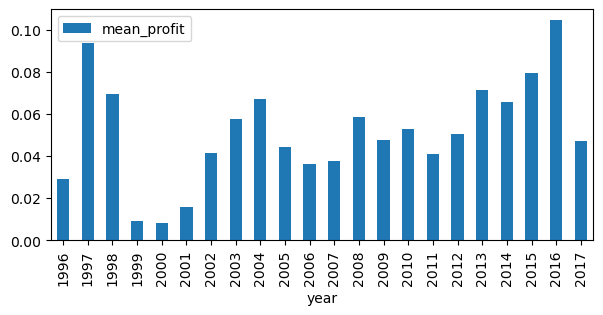

NameError: name 'profit' is not defined

<Axes: xlabel='weekday'>

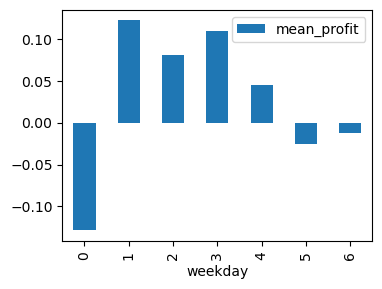

<Axes: xlabel='day'>

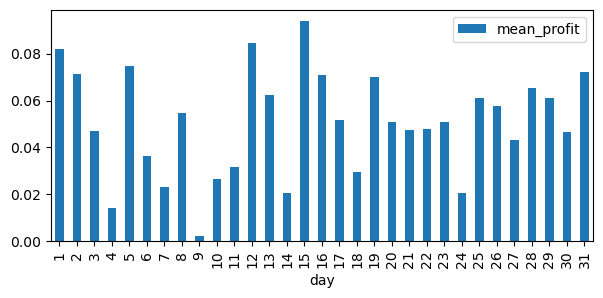

<Axes: xlabel='year'>

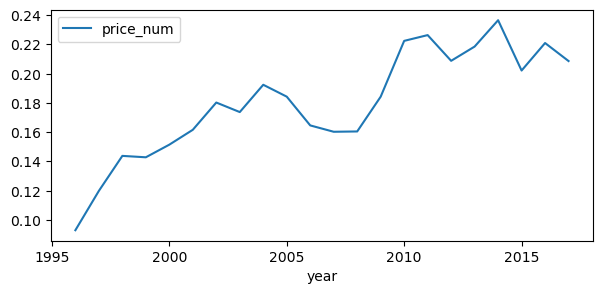

## 1.8 summary of feature engineering

- size info, i.e. height, width, depth are highly correlated. they are combined as a new feature 'volume'
- volume and weight are highly correlated, so we drop weight and keep volume (fine if we do the opposite)
- one-hot encoding for splitted individual product types (23 type in total), which are of low cardinality (percent level uniqueness). we keep first 10 or 15 leading types which account for 85% or 96% occourances.
- frequency encoding for maker and ingredient, which are of high cardinality
- label encoding for product level which appears as ordinal 
- convert purchase_date to year, month, weekday and day features

#### - start-to-end

In [3]:
# load dataset
df = pd.read_csv('../sales.csv') 

# drop null rows of price (removed 11 rows)
df.dropna(subset=['price'], inplace=True) 

# -------------------- convert volume, weight, cost, price to numerics --------------------
t2n = text2num()
df['height_num'] = df.height.map(t2n.height2num)
df['width_num'] = df.width.map(t2n.width2num)
df['depth_num'] = df.depth.map(t2n.depth2num)
df['weight_num'] = df.weight.map(t2n.weight2num)
df['cost_num'] = df.cost.map(t2n.cost2num)
df['price_num'] = df.price.map(t2n.price2num)

# -------------------- create volume to replace heigth/width/depth --------------------
df['volume'] = df['height_num'] * df['width_num'] * df['depth_num'] # unit m^3

# -------------------- add year, month, weekday, day --------------------
df['purchase_date'] = pd.to_datetime(df.purchase_date)
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month
df['weekday'] = df['purchase_date'].dt.weekday
# df['day'] = df['purchase_date'].dt.day

#------------------ one-hot encoding for poduct_type --------------------
# split and count for each individual product type
map = {}
for e in df.product_type:
    if type(e) == str:
        tmp = e.split(',')
        for i in tmp:
            map[i] = map.get(i,0)+1

sorted_types = sorted(map.items(), key=lambda item:item[1], reverse=True)
product_type, count = zip(*sorted_types)

# column to temporarily store lists of the product types 
df['product_type_tmp'] = df['product_type'].apply(lambda x: [tag.strip() for tag in x.split(',')] if type(x)==str else [])

# individual types to create as new features
new_types = []
for i in sorted_types[0:10]:
    new_types.append(i[0])
new_types.append('Other')

for tag in new_types:
    df[f'type_{tag}'] = df['product_type_tmp'].apply(lambda x: 1 if tag in x else 0)

df.drop(columns='product_type_tmp', inplace=True)

#------------------ label encoding for poduct_level --------------------
def convert_level_2_ordinal(x):
    convert = {"unrated": 0, "basic": 1, "intermediate": 2, "advanced": 3, "super advanced": 4}
    if x in convert:
        return convert[x]
    else:
        return x

df['product_level_num'] = df['product_level'].map(convert_level_2_ordinal)

#------------------ frequency encoding for maker --------------------
maker_freq = {}
makers = list(df.maker.unique())
for maker in makers:
    maker_freq[maker] = df[df['maker']==maker]['maker'].count()

df['maker_freq'] = df['maker'].map(lambda x: maker_freq[x])

#------------------ frequency encoding for ingredient --------------------
# ingredient_freq = {}
# ingredients = list(df.ingredient.unique())
# for ingredient in ingredients:
#     ingredient_freq[ingredient] = df[df['ingredient']==ingredient]['ingredient'].count()

# df['ingredient_freq'] = df['ingredient'].map(lambda x: ingredient_freq[x])



df.head().T

,0,1,2,3,4
cost,$333k,NaN,$270k,NaN,$97k
price,"$300,492","$430,570","$213,070","$229,174","$122,659"
weight,3 Ton 90 Kg,3 Ton 30 Kg,3 Ton 40 Kg,3 Ton 50 Kg,2 Ton 970 Kg
purchase_date,2008-12-19 00:00:00,1997-09-10 00:00:00,2001-09-05 00:00:00,2016-12-23 00:00:00,2000-01-12 00:00:00
product_type,"Q,B","J,D","J,D",U,"D,R"
product_level,advanced,basic,basic,advanced,advanced
maker,M14122,NaN,NaN,M14123,NaN
ingredient,"IN732052,IN732053","IN732054,IN732055,IN732056,IN732057,IN732058","IN732054,IN732059,IN732060","IN732061,IN732062,IN732063","IN732064,IN732065,IN732066"
height,2.76 meters,2.67 meters,3.0 meters,2.5 meters,2.47 meters
width,97 cm,98 cm,93 cm,102 cm,101 cm


#### - feature selection 

In [4]:
df.columns

Index(['cost', 'price', 'weight', 'purchase_date', 'product_type',
       'product_level', 'maker', 'ingredient', 'height', 'width', 'depth',
       'height_num', 'width_num', 'depth_num', 'weight_num', 'cost_num',
       'price_num', 'volume', 'year', 'month', 'weekday', 'type_D', 'type_H',
       'type_A', 'type_U', 'type_N', 'type_R', 'type_B', 'type_C', 'type_J',
       'type_S', 'type_Other', 'product_level_num', 'maker_freq'],
      dtype='object')

In [5]:
df_new = df[['price_num',
        # 'height_num', 'width_num', 'depth_num',  # combined as volume
        # 'weight_num', # drop either weight or volume, as the two are highly correlated
        'cost_num',
        'volume',
    #    'price_num',  # target variable
       'type_D', 'type_H', 'type_A',
       'type_U', 'type_N', 'type_R', 'type_B', 'type_C', 'type_J', 'type_S',
      #  'type_F', 'type_K', 'type_T', 'type_Q', 'type_P', 
       'type_Other',
    #   'type_V', 'type_G','type_W', 'type_M', 'type_L', 'type_E', 'type_I', 'type_O',
       'product_level_num', 
       'maker_freq',
      #  'ingredient_freq',
       'year', 'month', 'weekday', 
      #  'day',
       ]]
df_new.head().T

,0,1,2,3,4
price_num,0.300492,0.430570,0.21307,0.229174,0.122659
cost_num,0.333000,NaN,0.27000,NaN,0.097000
volume,0.696072,0.680316,0.66960,0.688500,0.648622
type_D,0.000000,1.000000,1.00000,0.000000,1.000000
type_H,0.000000,0.000000,0.00000,0.000000,0.000000
type_A,0.000000,0.000000,0.00000,0.000000,0.000000
type_U,0.000000,0.000000,0.00000,1.000000,0.000000
type_N,0.000000,0.000000,0.00000,0.000000,0.000000
type_R,0.000000,0.000000,0.00000,0.000000,1.000000
type_B,1.000000,0.000000,0.00000,0.000000,0.000000


#### - (exploratory) other cost imputation?
- KNN (K-nearest neighbors)
- MICE (Multiple Imputation by Chained Equations)

In [55]:
steps = [
        # ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=2))
        ]
model = Pipeline(steps)

df_new = pd.DataFrame(model.fit_transform(df_new), columns=df_new.columns)
df_new.head().T

# imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
# X_imputed = imputer.fit_transform(X_train)

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import BayesianRidge  # or any regressor

,0,1,2,3,4
price_num,0.300492,0.430570,0.21307,0.229174,0.122659
cost_num,0.333000,0.160000,0.27000,0.167500,0.097000
volume,0.696072,0.680316,0.66960,0.688500,0.648622
type_D,0.000000,1.000000,1.00000,0.000000,1.000000
type_H,0.000000,0.000000,0.00000,0.000000,0.000000
type_A,0.000000,0.000000,0.00000,0.000000,0.000000
type_U,0.000000,0.000000,0.00000,1.000000,0.000000
type_N,0.000000,0.000000,0.00000,0.000000,0.000000
type_R,0.000000,0.000000,0.00000,0.000000,1.000000
type_B,1.000000,0.000000,0.00000,0.000000,0.000000


#### - train/test split

In [6]:
# split data according to year
split_year = 2015
train_raw = df_new[df_new.year < split_year].reset_index(drop=True)
test_raw = df_new[df_new.year >= split_year].reset_index(drop=True)
print(df_new.shape, 'train %.1f%%'%(train_raw.shape[0]/df_new.shape[0]*100), 'test %.1f%%'%(test_raw.shape[0]/df_new.shape[0]*100))

# preppare X_train, y_train, X_test, y_test
features = list(train_raw.columns)
target = 'price_num'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

X_train.head().T

(3186, 19) train 86.5% test 13.5%


,0,1,2,3,4
cost_num,0.333000,NaN,0.2700,0.097000,0.0590
volume,0.696072,0.680316,0.6696,0.648622,0.6504
type_D,0.000000,1.000000,1.0000,1.000000,0.0000
type_H,0.000000,0.000000,0.0000,0.000000,1.0000
type_A,0.000000,0.000000,0.0000,0.000000,0.0000
type_U,0.000000,0.000000,0.0000,0.000000,0.0000
type_N,0.000000,0.000000,0.0000,0.000000,0.0000
type_R,0.000000,0.000000,0.0000,1.000000,0.0000
type_B,1.000000,0.000000,0.0000,0.000000,0.0000
type_C,0.000000,0.000000,0.0000,0.000000,0.0000


# 2. REGRESSION MODELING 
- procedure 
    - create a new dataframe to hold selected & engineered features for modeling 
    - split data for train/test
    - build transformer and pipeline with different models (linear regression, tree models)
- model selection
    - linear regression: too simple for complex pricing patterns (e.g. higher product_level does not lead to higher price)
    - single tree tends to be highly overfit
    - XGBoost: better performance, but harder to explain and manage
    - Neural Networks: overkill for tabular data and harder to interpret
    - random forest may be a good balance among linear model, single tree, and xgboost

## 2.1 Linear Regression

train MAE: 1.07e-01
train MSE: 2.58e-02
train R2: 0.395
-----------
train MAE: 1.39e-01
train MSE: 5.28e-02
train R2: 0.387


Text(0, 0.5, 'feature coef')

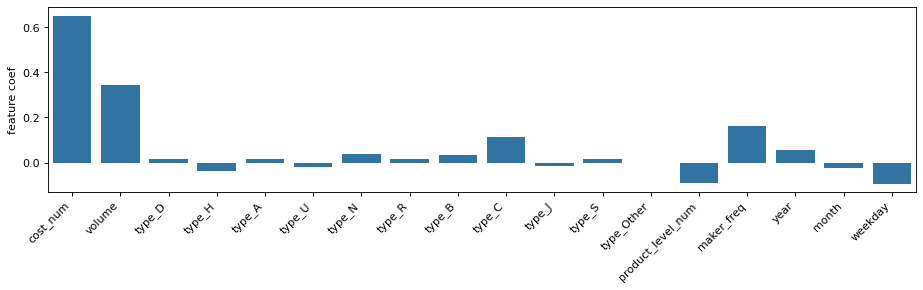

In [7]:
steps = [('tf', features_transformer()), 
        #  ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

# plot feature coefficients
plt.figure(figsize=[14,3],dpi=80)
sns.barplot(model.steps[len(steps)-1][1].coef_)
plt.xticks(range(len(model.steps[len(steps)-1][1].coef_)),X_train.columns, rotation=45, ha='right')
plt.ylabel('feature coef')

#### - regularization

train MAE: 1.06e-01
train MSE: 2.58e-02
train R2: 0.394
-----------
train MAE: 1.39e-01
train MSE: 5.32e-02
train R2: 0.383


Text(0, 0.5, 'feature coef')

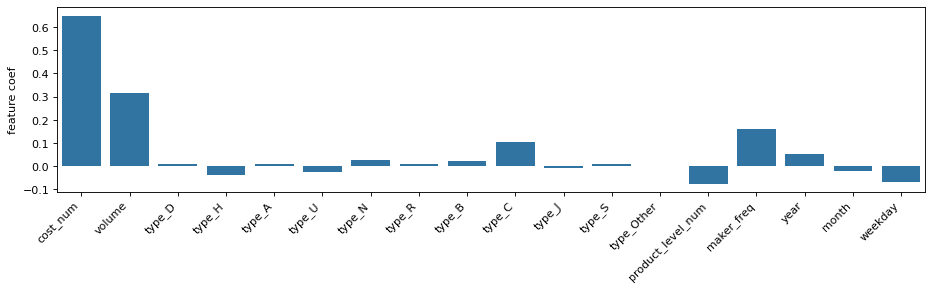

In [55]:
steps = [('tf', features_transformer()), 
        #  ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=0.0003))]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

# plot feature coefficients
plt.figure(figsize=[14,3],dpi=80)
sns.barplot(model.steps[len(steps)-1][1].coef_)
plt.xticks(range(len(model.steps[len(steps)-1][1].coef_)),X_train.columns, rotation=45, ha='right')
plt.ylabel('feature coef')

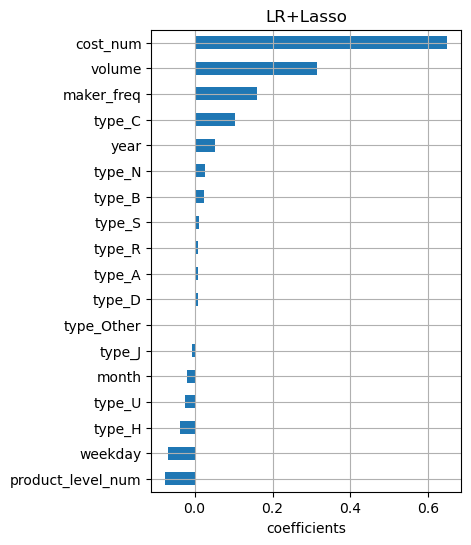

In [58]:
# plt.figure(figsize=[14,3],dpi=80)
# sns.barplot(model.steps[len(steps)-1][1].coef_)
# plt.xticks(range(len(model.steps[len(steps)-1][1].coef_)),X_train.columns, rotation=45, ha='right')
# plt.ylabel('feature coef')
df_importance = pd.DataFrame({'feature': X_train.columns,
    'coefficients': model.steps[len(steps)-1][1].coef_})
df_importance_sorted = df_importance.sort_values(by='coefficients', ascending=True)
df_importance_sorted.set_index('feature')['coefficients'].plot(kind='barh', 
                figsize=(4,6), xlabel='coefficients',ylabel='',title='LR+Lasso')
plt.grid(which='both')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-02, tolerance: 1.175e-02
  model = cd_fast.enet_coordinate_descent(


train MAE: 1.00e-01
train MSE: 2.40e-02
train R2: 0.437
-----------
train MAE: 1.29e-01
train MSE: 4.86e-02
train R2: 0.436


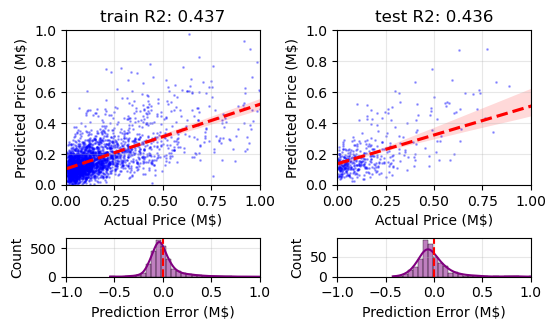

In [ ]:
steps = [('tf', features_transformer()), 
         ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=0.0003))]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

#### - hyperparameter tuning

In [10]:
alpha_ = np.linspace(0,0.001,11)
train_r2_ = []
test_r2_ = []
for alpha in alpha_:
    steps = [('ft', features_transformer()), 
         ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=alpha))]
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)

    train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test, slient=True)
    train_r2_.append(train_r2)
    test_r2_.append(test_r2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.992e+01, tolerance: 1.175e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

Text(0.5, 0, 'Lasso alpha')

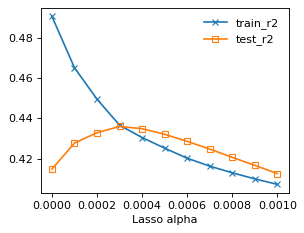

In [11]:
plt.figure(figsize=[4,3],dpi=80)
plt.plot(alpha_, train_r2_, '-x', label='train_r2')
plt.plot(alpha_, test_r2_, '-s', markerfacecolor='none', label='test_r2')
plt.legend(loc=1, frameon=False)
plt.xlabel('Lasso alpha')

## 2.2 Decision Tree
- single decision tree regressor tends to overfit train data

train MAE: 0.00e+00
train MSE: 0.00e+00
train R2: 1.000
-----------
train MAE: 1.59e-01
train MSE: 7.57e-02
train R2: 0.122


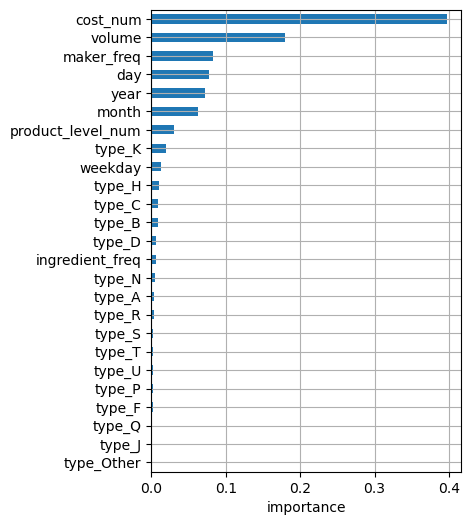

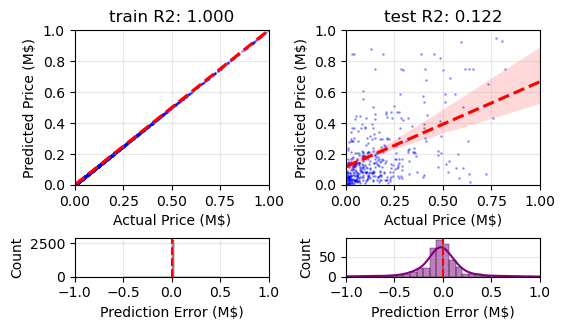

In [64]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('tree', DecisionTreeRegressor(random_state=42))
         ]
model = Pipeline(steps)
model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

## 2.3 Random Forest

train MAE: 3.65e-02
train MSE: 3.54e-03
train R2: 0.917
-----------
train MAE: 1.25e-01
train MSE: 4.87e-02
train R2: 0.436


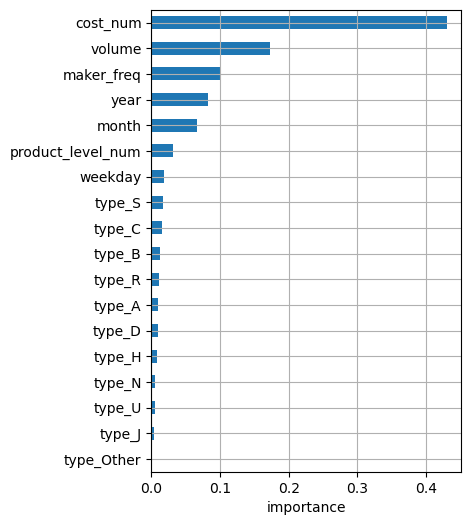

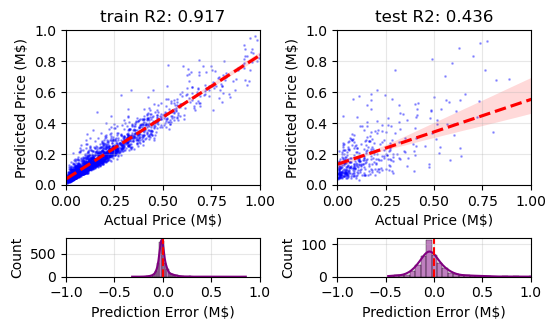

In [15]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('tree', RandomForestRegressor(n_estimators=100, random_state=42))
         ]
model = Pipeline(steps)
model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

#### - hyperprameter tuning

In [27]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('rf', RandomForestRegressor()) 
         ]

model = Pipeline(steps)

kf = KFold(n_splits= 5, shuffle= True, random_state= 42)

param_grid = {
    # 'tree__n_estimators': [50, 100,200,400],
    # 'tree__max_depth': [5, 10, 15],
    # 'tree__min_samples_split': [2, 5, 10, 20],
    # 'tree__min_samples_leaf': [2, 5, 10, 20],
    # 'tree__max_features': ['sqrt', 'log2', 'auto']
    'rf__n_estimators': [100,200, 300],
    'rf__max_depth': range(5,15),
    'rf__min_samples_split': range(2,10), #[2, 5, 10, 20],
    'rf__min_samples_leaf': range(2,10), #[2, 5, 10, 20],
}

random_search_rf = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=400, 
    scoring='neg_mean_squared_error',
    cv=kf,
    verbose=2,
    n_jobs=8,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END rf__max_depth=13, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=200; total time=   0.8s
[CV] END rf__max_depth=13, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=200; total time=   0.8s
[CV] END rf__max_depth=13, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=200; total time=   0.9s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=6, rf__n_estimators=300; total time=   1.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=6, rf__n_estimators=300; total time=   1.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=6, rf__n_estimators=300; total time=   1.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=6, rf__n_estimators=300; total time=   1.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__min_samples_split=6, rf__n_estimators=300; total time=   1.1s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('ft',
                                              <__main__.features_transformer object at 0x169be1af0>),
                                             ('rescale', MinMaxScaler()),
                                             ('rf', RandomForestRegressor())]),
                   n_iter=400, n_jobs=8,
                   param_distributions={'rf__max_depth': range(5, 15),
                                        'rf__min_samples_leaf': range(2, 10),
                                        'rf__min_samples_split': range(2, 10),
                                        'rf__n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

train MAE: 8.21e-02
train MSE: 1.70e-02
train R2: 0.601
-----------
train MAE: 1.22e-01
train MSE: 5.08e-02
train R2: 0.411


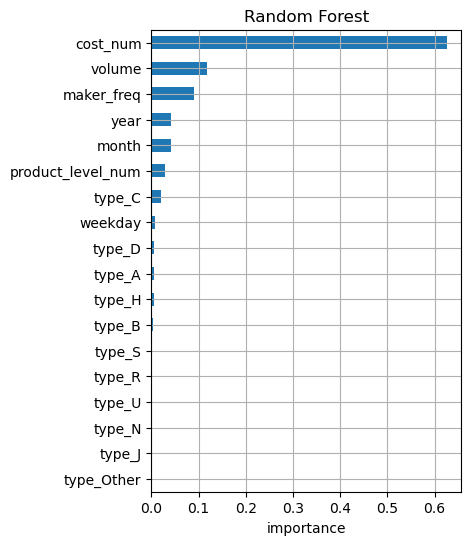

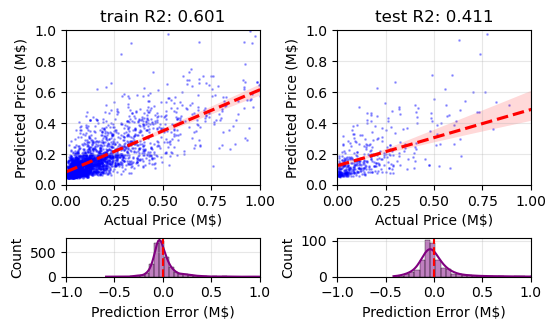

In [60]:
model = random_search_rf.best_estimator_

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='',title='Random Forest')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

In [30]:
random_search_rf.best_estimator_

Pipeline(steps=[('ft', <__main__.features_transformer object at 0x16a987f80>),
                ('rescale', MinMaxScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=9, min_samples_leaf=7,
                                       min_samples_split=6,
                                       n_estimators=200))])

## 2.4 gradient boosting trees

train MAE: 8.37e-02
train MSE: 1.55e-02
train R2: 0.637
-----------
train MAE: 1.20e-01
train MSE: 4.96e-02
train R2: 0.424


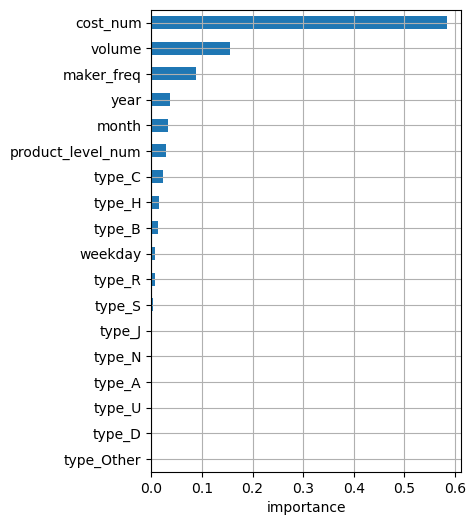

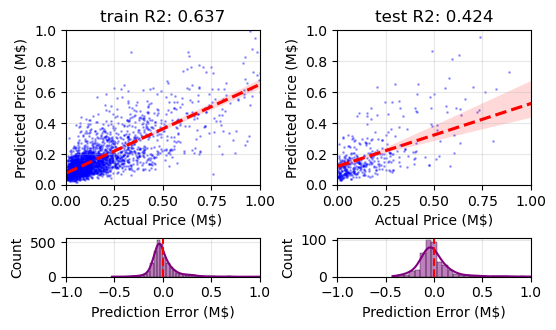

In [63]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('gbr', GradientBoostingRegressor(random_state=42))
         ]
model = Pipeline(steps)
model.fit(X_train, y_train)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)


#### - hyperparameter tuning

In [64]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('gbr', GradientBoostingRegressor())
         ]

model = Pipeline(steps)

kf = KFold(n_splits= 5, shuffle= True, random_state= 42)

param_grid = {
    'gbr__n_estimators': [50, 100],
    'gbr__learning_rate': [0.01, 0.1, 0.3],
    'gbr__max_depth': [5, 10, 20],
    'gbr__min_samples_split': [2, 5, 10],
    'gbr__min_samples_leaf': [2, 5, 10]
}

random_search_gbr = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=400, 
    scoring='neg_mean_squared_error',
    cv=kf,
    verbose=2,
    n_jobs=8,
    random_state=42
)

random_search_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 162 is smaller than n_iter=400. Running 162 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=50; total time=   0.1s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=50; total time=   0.1s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=50; total time=   0.1s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=50; total time=   0.1s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=50; total time=   0.1s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=100; total time=   0.3s
[CV] END gbr__learning_rate=0.01, gbr__max_depth=5, gbr__min_samples_leaf=2, gbr__min_samples_split=2, gbr__n_estimators=100; total tim

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('ft',
                                              <__main__.features_transformer object at 0x16a4f20c0>),
                                             ('rescale', MinMaxScaler()),
                                             ('gbr',
                                              GradientBoostingRegressor())]),
                   n_iter=400, n_jobs=8,
                   param_distributions={'gbr__learning_rate': [0.01, 0.1, 0.3],
                                        'gbr__max_depth': [5, 10, 20],
                                        'gbr__min_samples_leaf': [2, 5, 10],
                                        'gbr__min_samples_split': [2, 5, 10],
                                        'gbr__n_estimators': [50, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

train MAE: 7.93e-02
train MSE: 1.41e-02
train R2: 0.669
-----------
train MAE: 1.18e-01
train MSE: 4.93e-02
train R2: 0.428


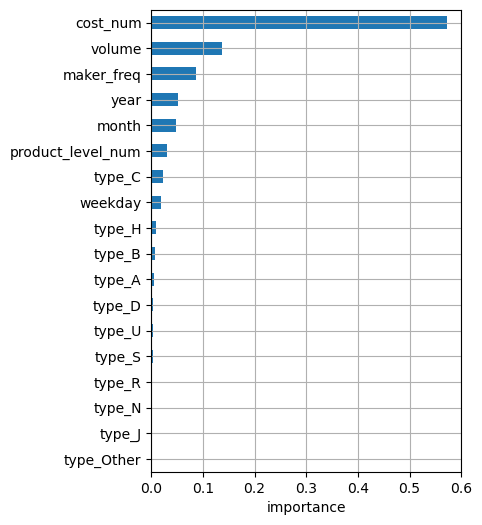

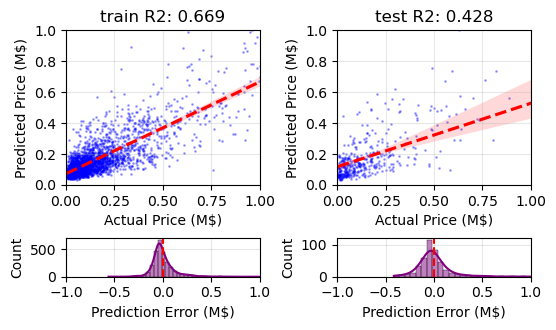

In [66]:
model = random_search_gbr.best_estimator_

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

## 2.5 Xgboost

train MAE: 2.85e-02
train MSE: 1.63e-03
train R2: 0.962
-----------
train MAE: 1.24e-01
train MSE: 4.77e-02
train R2: 0.446


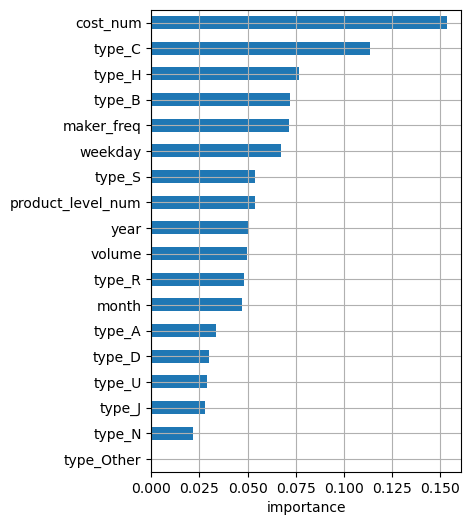

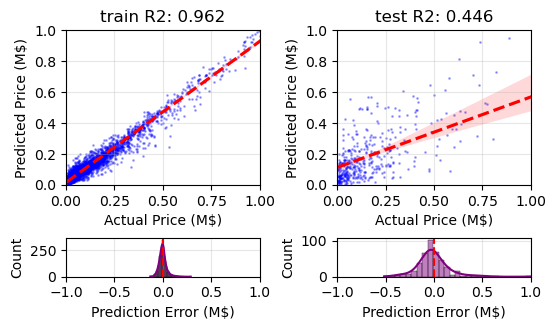

In [31]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('xgb', XGBRegressor(random_state=42))
         ]
model = Pipeline(steps)
model.fit(X_train, y_train)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

#### - hyperparameter tuning

In [69]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('xgb', XGBRegressor())
         ]

model = Pipeline(steps)

kf = KFold(n_splits= 5, shuffle= True, random_state= 42)

# param_grid = {
#     'xgb__n_estimators': range(100,501,50),  # Number of boosting rounds (trees)
#     'xgb__learning_rate': [0.01, 0.1, 0.5],  # Step size for each tree’s contribution
#     'xgb__max_depth': [5, 10, 15],  # Maximum depth of each tree
#     'xgb__min_child_weight': [1, 3, 5],  # Minimum sum of instance weight
#     'xgb__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
#     'xgb__colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for each tree
#     'xgb__alpha': [0.001, 0.01, 0.1, 1], # L1 regularization term on weights
# }
param_grid = {
    # Boosting and Learning
    'xgb__n_estimators': np.arange(100, 2001, 200),
    'xgb__learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1, 0.2],  # Extended lower values
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Stochastic boosting
    
    # Tree Structure
    'xgb__max_depth': np.arange(3, 10),
    'xgb__min_child_weight': [1, 2, 4, 6, 8, 10], 
    'xgb__gamma': [0, 0.01, 0.1, 1, 5],  # Min loss reduction for splits
    
    # Regularization
    'xgb__reg_alpha': [0, 0.1, 1, 10],  # L1 regularization
    'xgb__reg_lambda': [0, 0.1, 1, 10],  # L2 regularization
    
    # Feature Subsampling
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # of features per tree
    'xgb__colsample_bylevel': [0.6, 0.7, 0.8, 1.0],  # of features per split level
}

random_search_xgb = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=400, 
    scoring='neg_mean_squared_error',
    # scoring='r2',
    cv=kf,
    verbose=2,
    n_jobs=8,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END xgb__colsample_bylevel=1.0, xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=10, xgb__reg_lambda=10, xgb__subsample=0.9; total time=   0.1s
[CV] END xgb__colsample_bylevel=1.0, xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=10, xgb__reg_lambda=10, xgb__subsample=0.9; total time=   0.1s
[CV] END xgb__colsample_bylevel=1.0, xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=10, xgb__reg_lambda=10, xgb__subsample=0.9; total time=   0.1s
[CV] END xgb__colsample_bylevel=1.0, xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=10, xgb__reg_la

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('ft',
                                              <__main__.features_transformer object at 0x16a4988c0>),
                                             ('rescale', MinMaxScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,...
                                        'xgb__learning_rate': [0.001, 0.01,
                                                               0.02, 0.05, 0.1,
                                                               0.2],
                                        'xgb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'xgb__min_child_weight': [1, 2, 4, 6, 8,
                                                                  10],
                                        'xgb__n_estimators': array([ 100,  300,  500,  700,  900, 1100, 1300, 1500, 1700, 1900]),
                                        'xgb__reg_alpha': [0, 0.1, 1, 10],
                                        'xgb__reg_lambda': [0, 0.1, 1, 10],
                                        'xgb__subsample': [0.6, 0.7, 0.8, 0.9,
                                                           1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

train MAE: 7.84e-02
train MSE: 1.43e-02
train R2: 0.664
-----------
train MAE: 1.18e-01
train MSE: 4.69e-02
train R2: 0.456


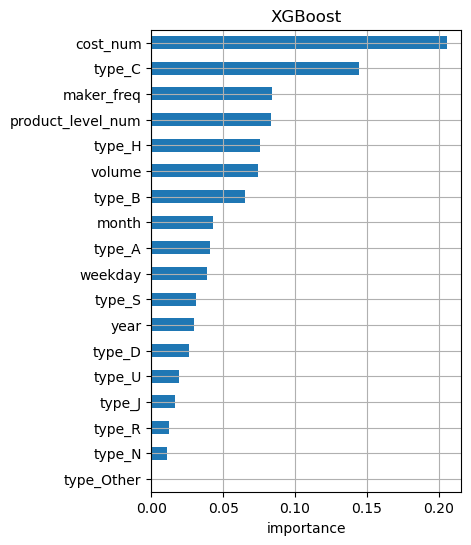

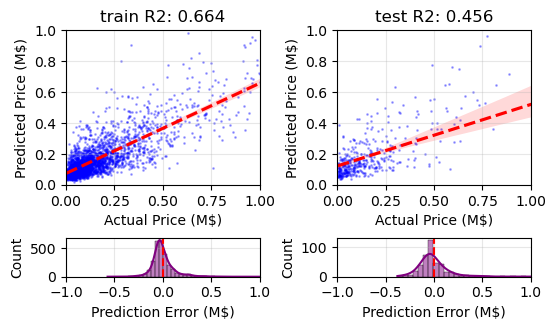

In [70]:
model = random_search_xgb.best_estimator_

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='',title='XGBoost')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

In [71]:
random_search_xgb.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('ft', <__main__.features_transformer object at 0x3057db380>),
                ('rescale', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=0.6, colsample_bynode=None,
                              colsample_bytree=0.6, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None, gamma=0,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None, min_child_weight=8,
           

<Figure size 1200x800 with 0 Axes>

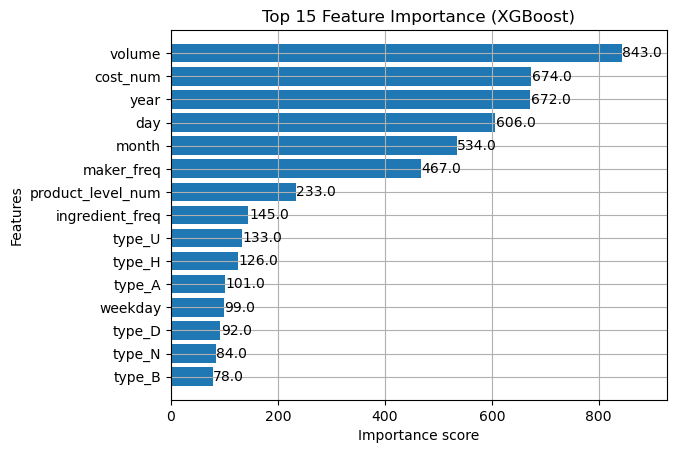

In [78]:
final_model = random_search.best_estimator_.named_steps['tree']

final_model.get_booster().feature_names = features 

plt.figure(figsize=(12, 8))
plot_importance(final_model, 
                max_num_features=15,
                height=0.8,
                importance_type='weight',
                title='Top 15 Feature Importance (XGBoost)')
plt.show()

## 2.6 summary of different models

In [36]:
models = ['LR+Poly+Lasso', 'randomForest', 'XGBoost']
models_train_mae = []
models_train_mse = []
models_train_r2 = []
models_test_mae = []
models_test_mse = []
models_test_r2 = []

# LR+Poly+Lasso
steps = [('tf', features_transformer()), 
         ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=0.0003))]
model = Pipeline(steps)
model = model.fit(X_train, y_train)
train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
models_train_mae.append(train_mae)
models_train_mse.append(train_mse)
models_train_r2.append(train_r2)
models_test_mae.append(test_mae)
models_test_mse.append(test_mse)
models_test_r2.append(test_r2)

# rf
model = random_search_rf.best_estimator_
train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
models_train_mae.append(train_mae)
models_train_mse.append(train_mse)
models_train_r2.append(train_r2)
models_test_mae.append(test_mae)
models_test_mse.append(test_mse)
models_test_r2.append(test_r2)

# xgb
model = random_search_xgb.best_estimator_
train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
models_train_mae.append(train_mae)
models_train_mse.append(train_mse)
models_train_r2.append(train_r2)
models_test_mae.append(test_mae)
models_test_mse.append(test_mse)
models_test_r2.append(test_r2)

train MAE: 1.00e-01
train MSE: 2.40e-02
train R2: 0.437
-----------
train MAE: 1.29e-01
train MSE: 4.86e-02
train R2: 0.436
train MAE: 8.21e-02
train MSE: 1.70e-02
train R2: 0.601
-----------
train MAE: 1.22e-01
train MSE: 5.08e-02
train R2: 0.411
train MAE: 7.84e-02
train MSE: 1.43e-02
train R2: 0.664
-----------
train MAE: 1.18e-01
train MSE: 4.69e-02
train R2: 0.456


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-02, tolerance: 1.175e-02
  model = cd_fast.enet_coordinate_descent(


In [37]:
models_train_mae,models_train_mse,models_train_r2,models_test_mae,models_test_mse,models_test_r2

([0.10043579667949508, 0.08209627193897649, 0.07844024534729079],
 [0.024006862431309256, 0.016981430751970082, 0.014322784370367006],
 [0.43661517053383425, 0.6014855962263116, 0.6638777993972196],
 [0.12899619905334583, 0.12216703958785938, 0.11761021230875862],
 [0.048622694897842246, 0.05080435028365703, 0.0469125172632747],
 [0.4360042201876829, 0.41069825075942423, 0.45584131417541884])

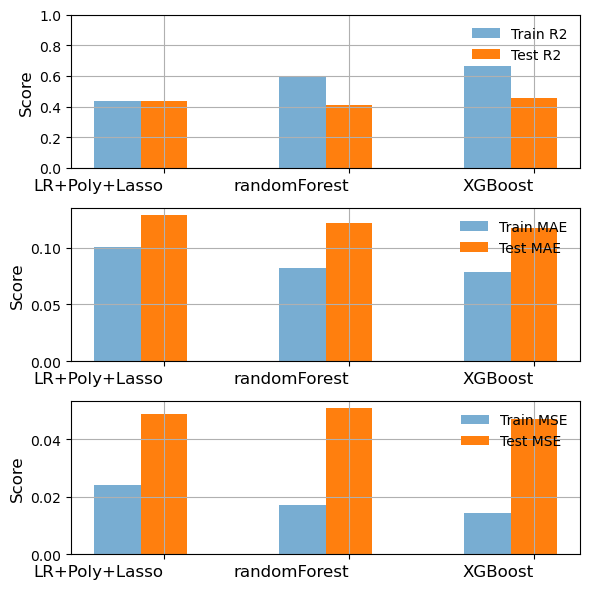

In [54]:
fig, axes = plt.subplots(3,1,figsize=(6, 6))
bar_width = 0.25
index = np.arange(len(models))
ax1=axes[0]
ax1.bar(index, models_train_r2, bar_width, label='Train R2', alpha=0.6)
ax1.bar(index + bar_width, models_test_r2, bar_width, label='Test R2', alpha=1)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Score',fontsize=12)
# ax1.set_title('Model Performance: Train R2, Test R2')
ax1.set_xticks(index + bar_width, models, rotation=0, ha='right',fontsize=12)
ax1.legend(loc=1,frameon=False)
ax1.grid(which='both')

ax1=axes[1]
ax1.bar(index, models_train_mae, bar_width, label='Train MAE', alpha=0.6)
ax1.bar(index + bar_width, models_test_mae, bar_width, label='Test MAE', alpha=1)
# ax1.set_ylim([0, 1])
ax1.set_ylabel('Score',fontsize=12)
# ax1.set_title('Model Performance: Train R2, Test R2')
ax1.set_xticks(index + bar_width, models, rotation=0, ha='right',fontsize=12)
ax1.legend(loc=1, frameon=False)
ax1.grid(which='both')

ax1=axes[2]
ax1.bar(index, models_train_mse, bar_width, label='Train MSE', alpha=0.6)
ax1.bar(index + bar_width, models_test_mse, bar_width, label='Test MSE', alpha=1)
# ax1.set_ylim([0, 1])
ax1.set_ylabel('Score',fontsize=12)
# ax1.set_title('Model Performance: Train R2, Test R2')
ax1.set_xticks(index + bar_width, models, rotation=0, ha='right',fontsize=12)
ax1.legend(loc=1, frameon=False)
ax1.grid(which='both')

plt.tight_layout()


# 3. MODEL INTERPRETATION

- use SHAP (Shapley Additive exPlanations) to explain model predictions

## 3.1 Tree models

train MAE: 2.52e-02
train MSE: 1.25e-03
train R2: 0.971
-----------
train MAE: 1.19e-01
train MSE: 4.57e-02
train R2: 0.470


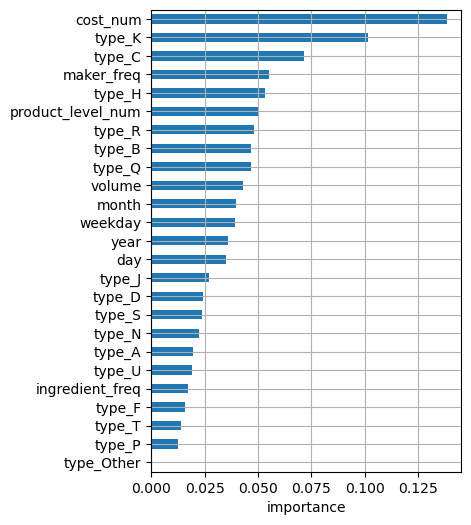

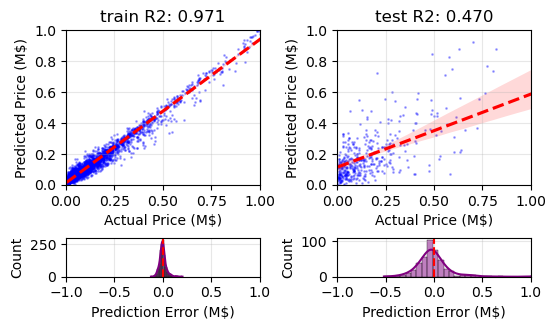

In [16]:
steps = [('ft', features_transformer()),
         ('rescale', MinMaxScaler()),
         ('tree', XGBRegressor())#n_estimators=400, random_state=42))
         ]
model = Pipeline(steps)
model.fit(X_train, y_train)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,6), xlabel='importance',ylabel='')
plt.grid(which='both')

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

<Figure size 1200x800 with 0 Axes>

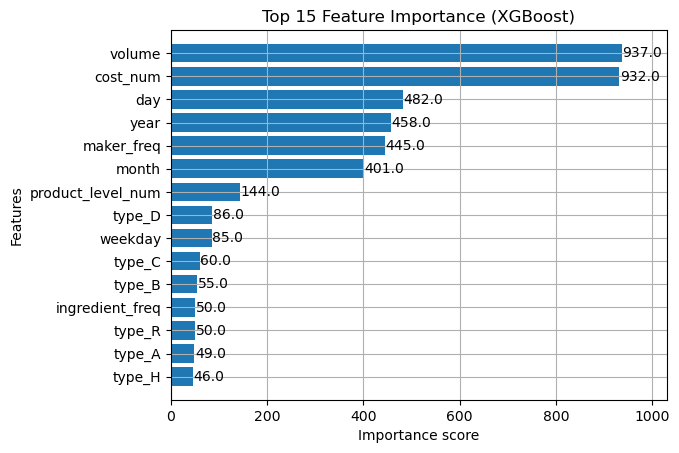

In [17]:
final_model = model.steps[len(steps)-1][1]

final_model.get_booster().feature_names = features 

plt.figure(figsize=(12, 8))
plot_importance(final_model, 
                max_num_features=15,
                height=0.8,
                importance_type='weight',
                title='Top 15 Feature Importance (XGBoost)')
plt.show()

In [10]:
explainer = shap.TreeExplainer(model.steps[len(steps)-1][1], X_train)  # use shap.Explainer for linear models
shap_values = explainer(X_test)


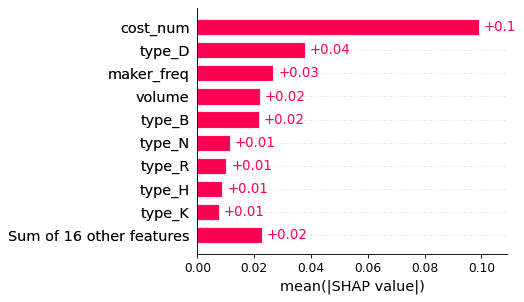

In [12]:
fig, ax1 = plt.subplots(1,1,figsize=[5,4],dpi=80)
shap.plots.bar(shap_values, ax=ax1)  # Shows average feature impact on predictions

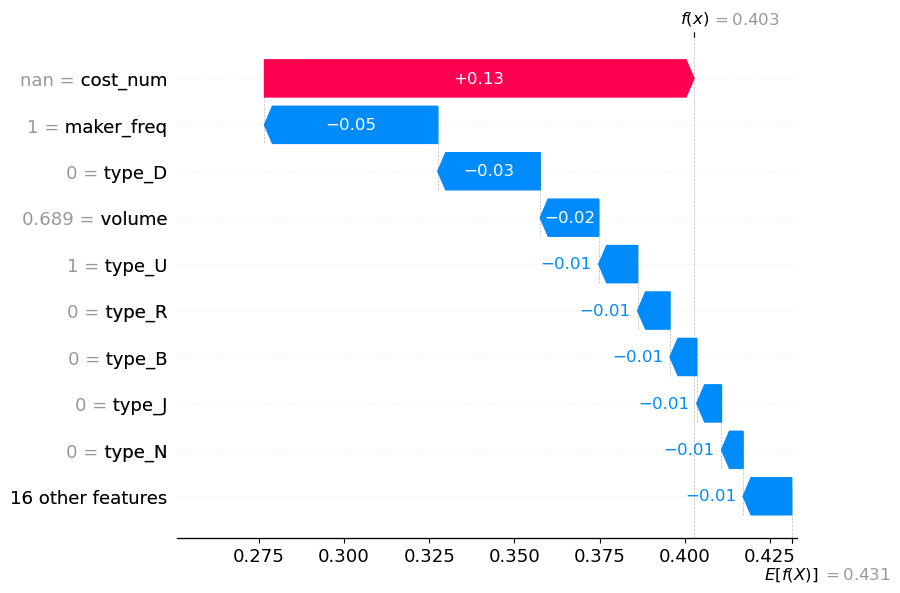

In [13]:
# fig, ax1 = plt.subplots(1,1,figsize=[4,3],dpi=80)
shap.plots.waterfall(shap_values[0])  # Explains prediction for first instance in X_test


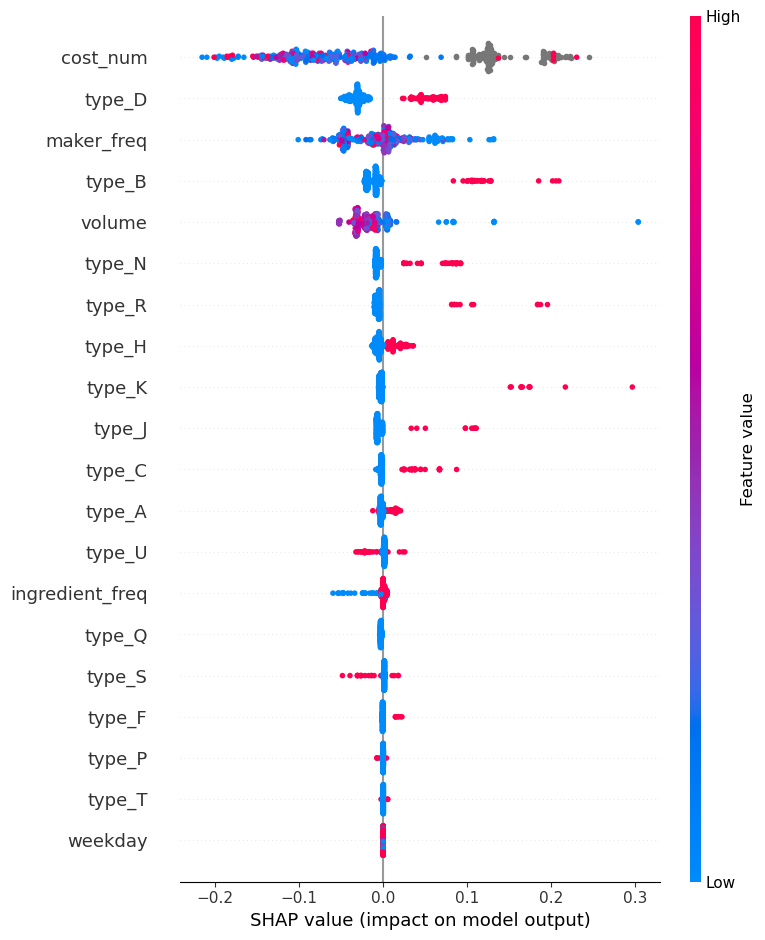

In [101]:
shap.summary_plot(shap_values, X_test)


## 3.2 Linear model

train MAE: 1.07e-01
train MSE: 2.55e-02
train R2: 0.402
-----------
train MAE: 1.39e-01
train MSE: 5.22e-02
train R2: 0.394


Text(0, 0.5, 'feature coef')

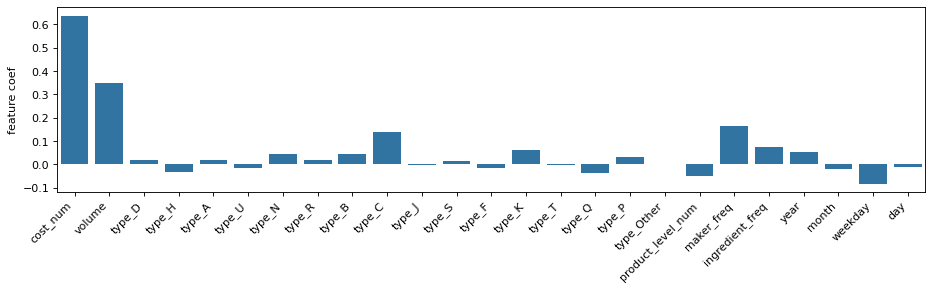

In [16]:
steps = [
        ('tf', features_transformer()), 
        #  ('poly', PolynomialFeatures()),
         ('rescale', MinMaxScaler()),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

# plot feature coefficients
plt.figure(figsize=[14,3],dpi=80)
sns.barplot(model.steps[len(steps)-1][1].coef_)
plt.xticks(range(len(model.steps[len(steps)-1][1].coef_)),X_train.columns, rotation=45, ha='right')
plt.ylabel('feature coef')

In [17]:
explainer = shap.Explainer(model.steps[len(steps)-1][1], X_train)  
shap_values = explainer(X_test)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


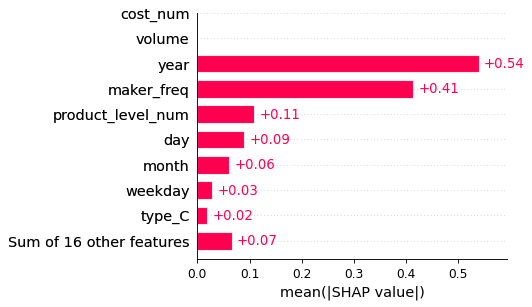

In [18]:
fig, ax1 = plt.subplots(1,1,figsize=[5,4],dpi=80)
shap.plots.bar(shap_values, ax=ax1)  # Shows average feature impact on predictions